# Sample v2 analysis

In [1]:
import os, json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn.cluster import KMeans

from dataclasses import dataclass


In [2]:
SAMPLE_DIR = "./sample-v2/api-10k-dump-tests"


## K-Means clustering, Outlier and others

### price extraction

In [3]:
prices = []
for file in os.listdir(SAMPLE_DIR):
    if file.endswith(".json"):
        with open(os.path.join(SAMPLE_DIR, file), 'r') as f:
            data = json.load(f)
            prices.append(data['priceInChaos'])
price_series = pd.Series(prices)
price_series


0        30.0
1        50.0
2        80.0
3        50.0
4        15.0
         ... 
48802    15.0
48803    15.0
48804    25.0
48805    10.0
48806     5.0
Length: 48807, dtype: float64

### price distribution

In [4]:
price_series.describe()

count    4.880700e+04
mean     6.621080e+03
std      8.274049e+05
min      0.000000e+00
25%      1.000000e+01
50%      3.900000e+01
75%      1.331300e+02
max      1.766988e+08
dtype: float64

In [5]:
price_distribution = price_series.value_counts().sort_index()
price_distribution

0.000000e+00     2
6.000000e-02     6
8.000000e-02    11
1.100000e-01    15
1.400000e-01     1
                ..
1.768757e+05    18
3.537513e+05     1
1.061254e+06     1
1.768757e+07     7
1.766988e+08     1
Name: count, Length: 357, dtype: int64

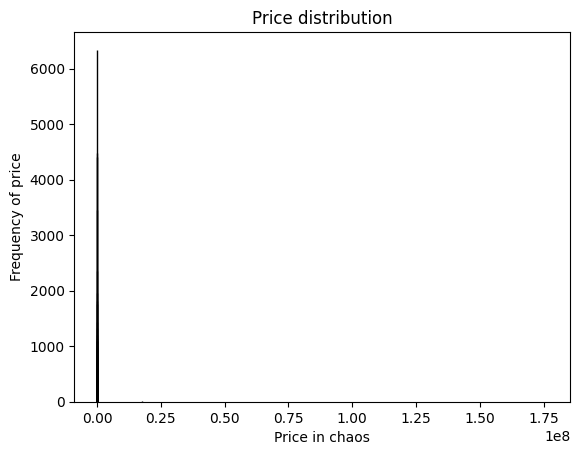

In [6]:
plt.bar(price_distribution.index, price_distribution.values, edgecolor='black')
plt.title("Price distribution")
plt.xlabel("Price in chaos")
plt.ylabel("Frequency of price")
plt.show()

<Axes: >

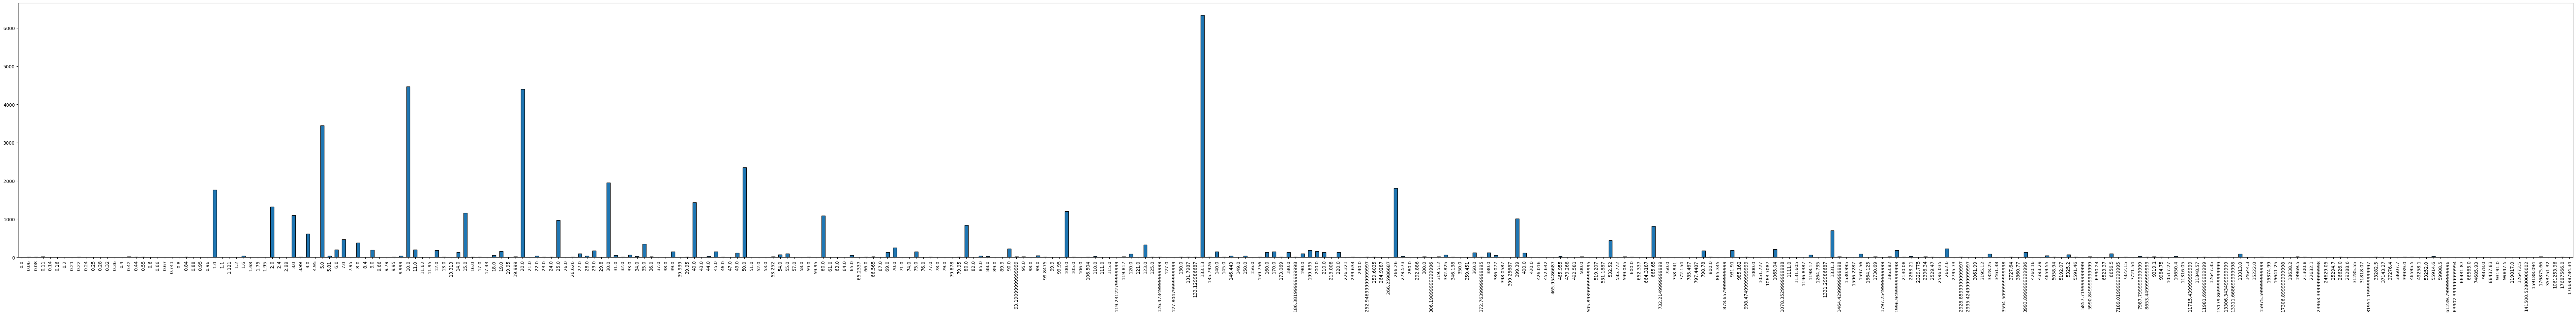

In [6]:
# not so readble, let's try with plot on pandas series directly
price_distribution.plot(kind='bar', logy=False, edgecolor='black', figsize=(100, 10))

<Axes: >

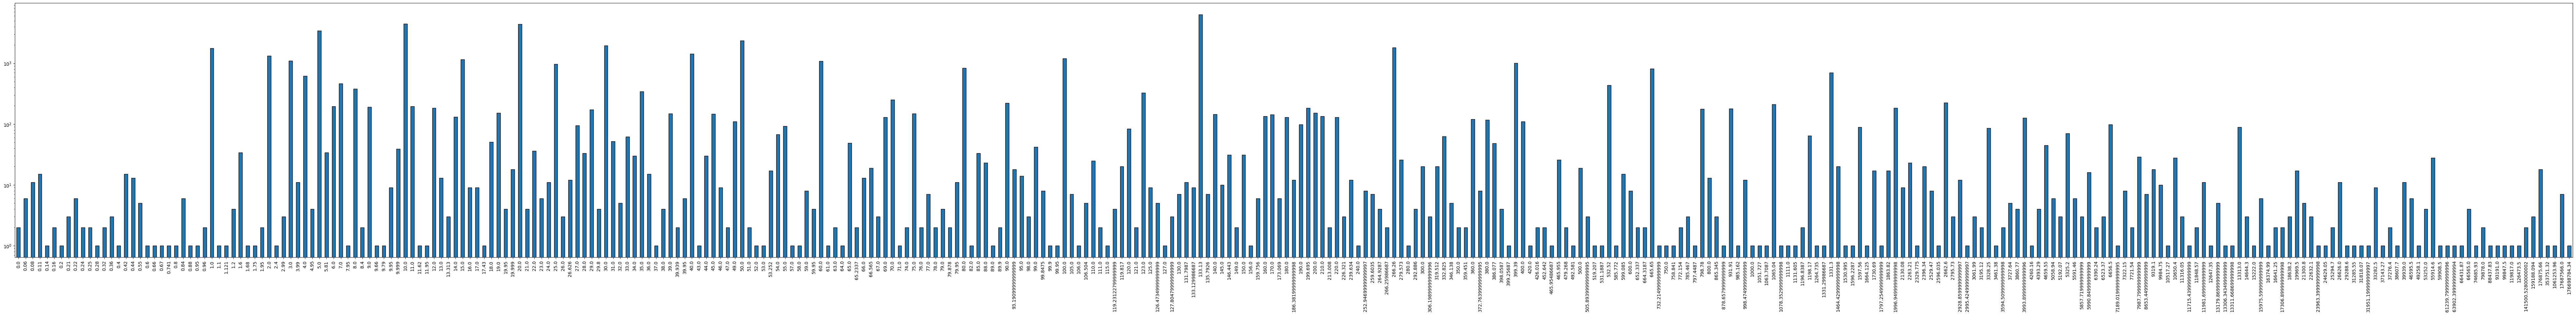

In [7]:
# and with log scale
price_distribution.plot(kind='bar', logy=True, edgecolor='black', figsize=(100, 10))

In [24]:
# high change to see clusters emerging

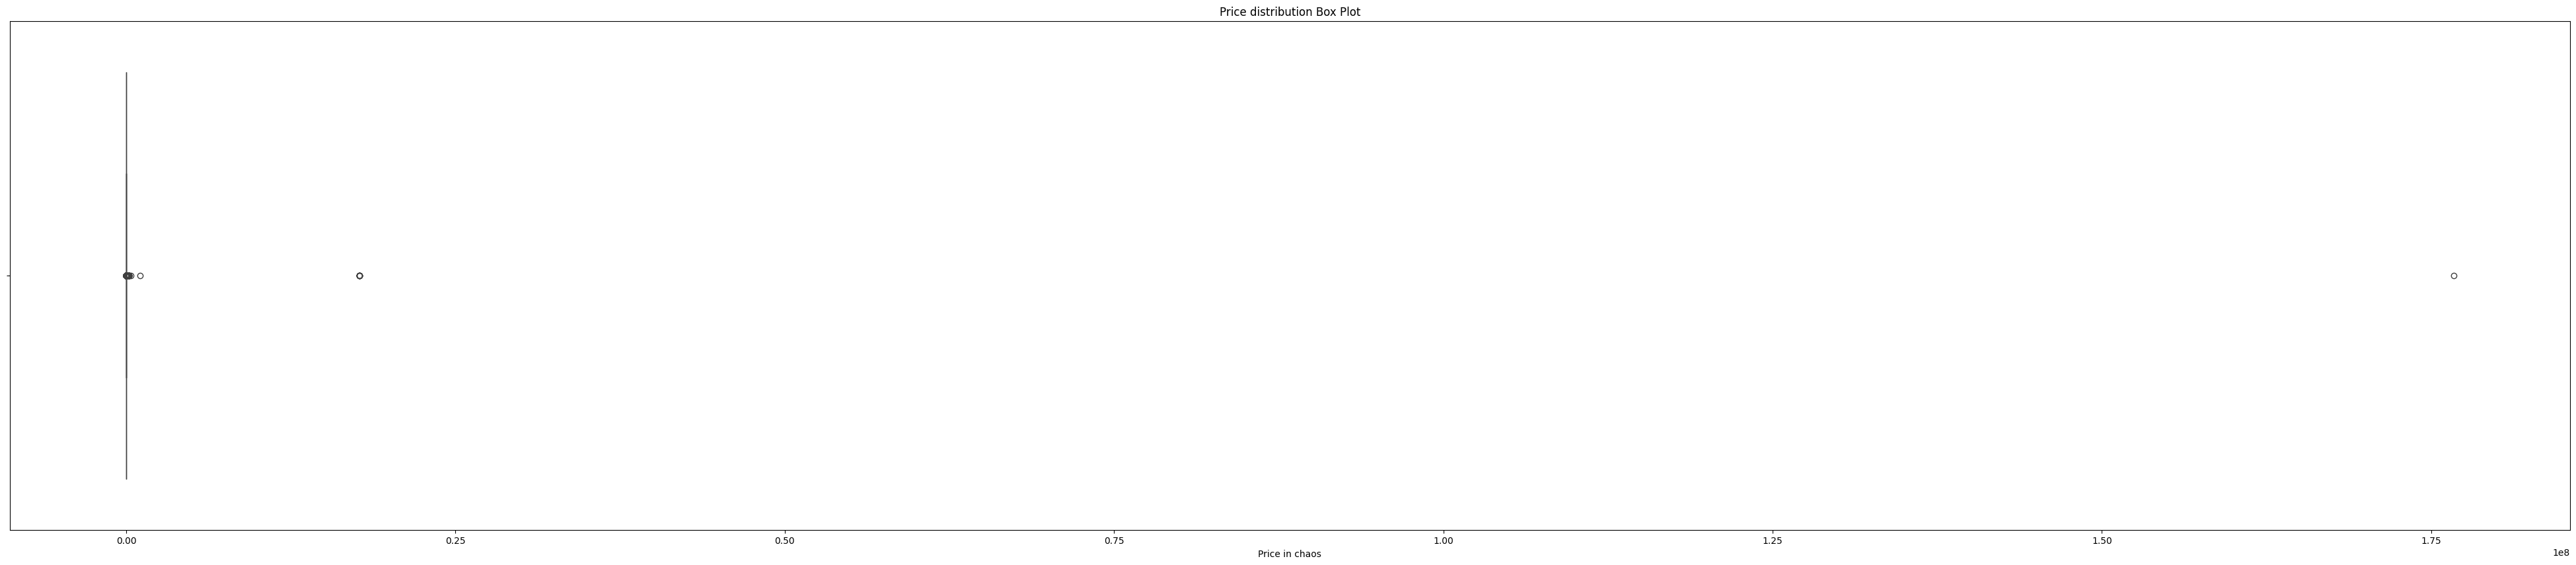

In [8]:
plt.figure(figsize=(50, 10))
sns.boxplot(x=prices)
plt.title("Price distribution Box Plot")
plt.xlabel("Price in chaos")
plt.show()

### Outlier detection

In [9]:
@dataclass
class PriceWithFileName:
    price: float
    name: str

prices_with_name = []
for file in os.listdir(SAMPLE_DIR):
    if file.endswith(".json"):
        with open(os.path.join(SAMPLE_DIR, file), 'r') as f:
            data = json.load(f)
            prices_with_name.append(PriceWithFileName(data['priceInChaos'], file))

In [10]:
@dataclass
class OutlierResult:
    lower_outliers: list[PriceWithFileName]
    upper_outliers: list[PriceWithFileName]
    not_outliers: list[PriceWithFileName]

    @property
    def outliers(self):
        return self.lower_outliers + self.upper_outliers
    
    def __post_init__(self):
        self.lower_outliers = sorted(self.lower_outliers, key=lambda p: p.price, reverse=True)
        self.upper_outliers = sorted(self.upper_outliers, key=lambda p: p.price, reverse=True)
    
    def __repr__(self) -> str:
        return f"OutlierResult(len lower_outliers={len(self.lower_outliers)}, lne upper_outliers={len(self.upper_outliers)}, len not_outliers={len(self.not_outliers)}, len outliers={len(self.outliers)})"


def outlier_analysis(prices_with_file_name: list[PriceWithFileName]) -> OutlierResult:
    prices_for_outlier_detection = np.array([price_with_file_name.price for price_with_file_name in prices_with_file_name])
    
    quantile_1 = np.percentile(prices_for_outlier_detection, 25)
    quantile_3 = np.percentile(prices_for_outlier_detection, 75)

    inter_quantile_range = quantile_3 - quantile_1
    lower_bound = quantile_1 - 1.5 * inter_quantile_range
    upper_bound = quantile_3 + 1.5 * inter_quantile_range
    
    upper_outliers = [price_with_file_name for price_with_file_name in prices_with_file_name if price_with_file_name.price > upper_bound]
    lower_outliers = [price_with_file_name for price_with_file_name in prices_with_file_name if price_with_file_name.price < lower_bound]
    not_outliers = [prices_with_file_name for prices_with_file_name in prices_with_file_name if lower_bound <= prices_with_file_name.price <= upper_bound]

    return OutlierResult(lower_outliers, upper_outliers, not_outliers)

In [11]:
first_outlier_detection = outlier_analysis(prices_with_name)
first_outlier_detection
# the number of outleir is way to high. It might indicate that the data can have a high volatility and sitll be consistent

OutlierResult(len lower_outliers=0, lne upper_outliers=5742, len not_outliers=43065, len outliers=5742)

In [12]:
# since the outliers are so high, let's try once again outlier detection on those outliers
second_outlier_detection = outlier_analysis(first_outlier_detection.upper_outliers)
second_outlier_detection
# the number of outliers looks better. Let's ask our subject matter expert if those data are reasonable

OutlierResult(len lower_outliers=0, lne upper_outliers=788, len not_outliers=4954, len outliers=788)

In [13]:
print(f"highest is {second_outlier_detection.upper_outliers[0].name} with price {second_outlier_detection.upper_outliers[0].price}")
print(f"lowest is {second_outlier_detection.upper_outliers[-1].name} with price {second_outlier_detection.upper_outliers[-1].price}")


highest is 08a14633cd899dbc87d53b3142097917cfbf69bc09361f81f58e308cae7fd817.json with price 176698784.34
lowest is 74025c0bef3560e0aedfe1e3d84db68c4b5307341d8bccee17321808cb0a633d.json with price 3461.38


In [14]:
# the highest price in the outliers is indeed too high to be reasonable and is an outlier
# the lowest price in the outleirs is reasonable and should not be an outlier
# let's try once again outlier detection on the outliers of the ouliers
third_outlier_detection = outlier_analysis(second_outlier_detection.upper_outliers)
third_outlier_detection
# the number of outliers is still looking fine. Let's ask our subject matter expert if those data are reasonable

OutlierResult(len lower_outliers=0, lne upper_outliers=127, len not_outliers=661, len outliers=127)

In [15]:
print(f"highest is {third_outlier_detection.upper_outliers[0].name} with price {third_outlier_detection.upper_outliers[0].price}")
print(f"lowest is {third_outlier_detection.upper_outliers[-1].name} with price {third_outlier_detection.upper_outliers[-1].price}")


highest is 08a14633cd899dbc87d53b3142097917cfbf69bc09361f81f58e308cae7fd817.json with price 176698784.34
lowest is 3b088486f3d8a18459e519243e5cb1d43f8560d7757258a9e38e1239201feb24.json with price 26626.0


In [16]:
# the highest price is still too high and the lowest price is still reasonable
# we will apply outlier detection once again on the outliers of the outliers of the outliers
forth_outlier_detection = outlier_analysis(third_outlier_detection.upper_outliers)
forth_outlier_detection

OutlierResult(len lower_outliers=0, lne upper_outliers=10, len not_outliers=117, len outliers=10)

In [17]:
print(f"highest is {forth_outlier_detection.upper_outliers[0].name} with price {forth_outlier_detection.upper_outliers[0].price}")
print(f"lowest is {forth_outlier_detection.upper_outliers[-1].name} with price {forth_outlier_detection.upper_outliers[-1].price}")


highest is 08a14633cd899dbc87d53b3142097917cfbf69bc09361f81f58e308cae7fd817.json with price 176698784.34
lowest is ee3bc7b002c7a8de9ac71d9e521dce40dae42f4c6c78d629959118cc9f5cbc41.json with price 353751.32


In [ ]:
# the lowest price is not reasonable anymore. So we have 10 real outliers in totral

### Price analysis without outliers

In [18]:
prices_without_outliers = []
for file in os.listdir(SAMPLE_DIR):
    if file.endswith(".json") and file not in [outlier.name for outlier in forth_outlier_detection.upper_outliers]:
        with open(os.path.join(SAMPLE_DIR, file), 'r') as f:
            data = json.load(f)
            prices_without_outliers.append(data['priceInChaos'])
price_without_outliers_series = pd.Series(prices_without_outliers)
price_without_outliers_series

0        30.0
1        50.0
2        80.0
3        50.0
4        15.0
         ... 
48792    15.0
48793    15.0
48794    25.0
48795    10.0
48796     5.0
Length: 48797, dtype: float64

In [59]:
names_without_outliers = []
for file in os.listdir(SAMPLE_DIR):
    if file.endswith(".json") and file not in [outlier.name for outlier in forth_outlier_detection.upper_outliers]:
        with open(os.path.join(SAMPLE_DIR, file), 'r') as f:
            data = json.load(f)
            names_without_outliers.append(data['id'])
names_without_outliers_series = pd.Series(names_without_outliers)
names_without_outliers_series

0        015d9b353acb20db3cdbc05f1386aab18cd5166d9b0bdd...
1        b3533b5e5ae6e2bd6d0f7bcca2239e78c4c422f84324fe...
2        7a70ed1d8643800ae1e2e596db3af8a9a9e5a32b2297ec...
3        a19cac5720bd4f47228521419907354dd0e5420ae01a00...
4        34c782d6ab2f88fc0b45dd2bfcd5db2edd65e5b00a588b...
                               ...                        
48792    439741f41e730850be431fd18738fd7b4a882be879bbd5...
48793    15952201ee3ccaaa0c4125887708d20b1d9c85015b81f9...
48794    8b9435a86f12d755156d8c45ee8f82a437bbfad2a4e3dc...
48795    96dd1a045f096d9a4244b98bf0c8b7c2744fb4e11502c9...
48796    0710755b85ca4d1cc1f939709f5c2949fe579cf9c629f5...
Length: 48797, dtype: object

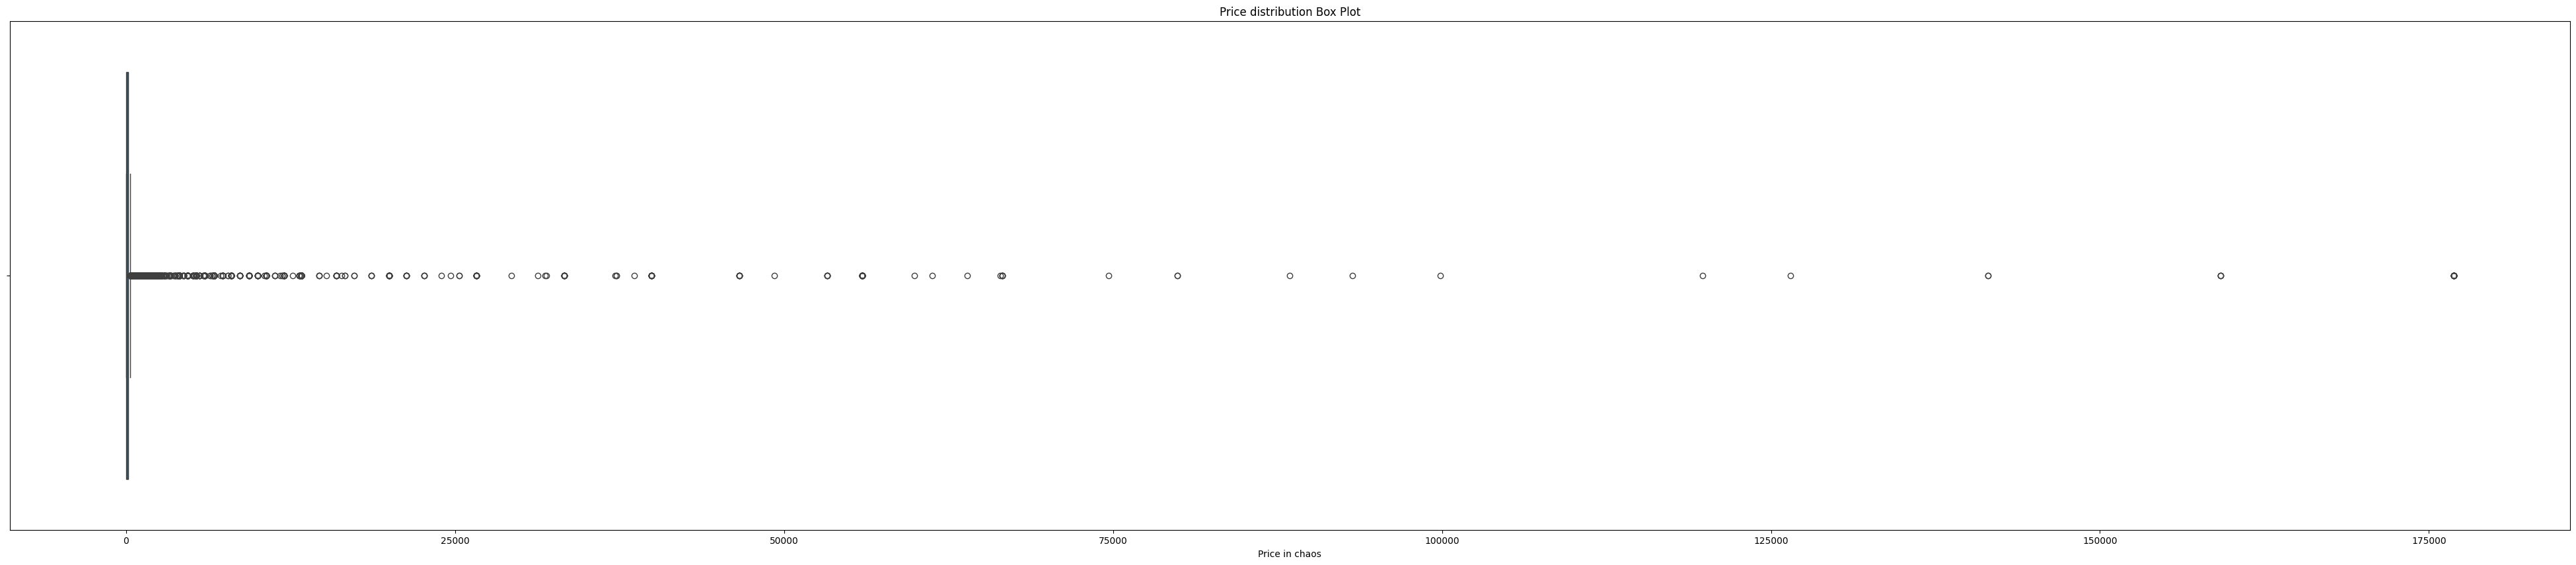

In [19]:
plt.figure(figsize=(50, 10))
sns.boxplot(x=prices_without_outliers)
plt.title("Price distribution Box Plot")
plt.xlabel("Price in chaos")
plt.show()

### K-means clustering

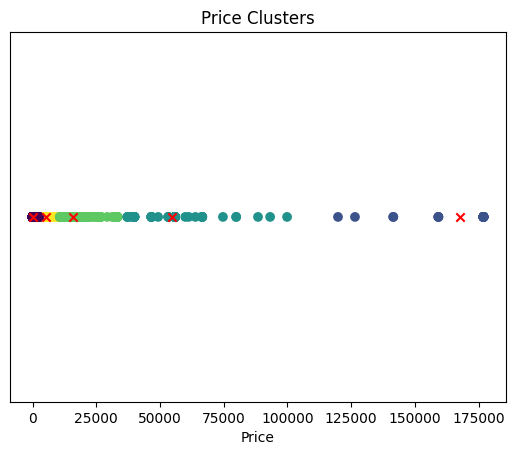

In [53]:
prices_array = np.array(prices_without_outliers).reshape(-1, 1)

# we assume 5 clusters: S, A, B, C, D
kmeans_with_outlier = KMeans(n_clusters=5, random_state=0)
price_clusters = kmeans_with_outlier.fit_predict(prices_array)

price_cluster_centers = kmeans_with_outlier.cluster_centers_ # for visualization

plt.scatter(prices_array, [0]*len(prices_array), c=price_clusters, cmap='viridis', marker='o')
plt.scatter(price_cluster_centers, [0]*len(price_cluster_centers), color='red', marker='x')  # cluster centers
plt.title('Price Clusters')
plt.xlabel('Price')
plt.yticks([])  # no need foy-axis
plt.show()

In [58]:
price_clusters

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

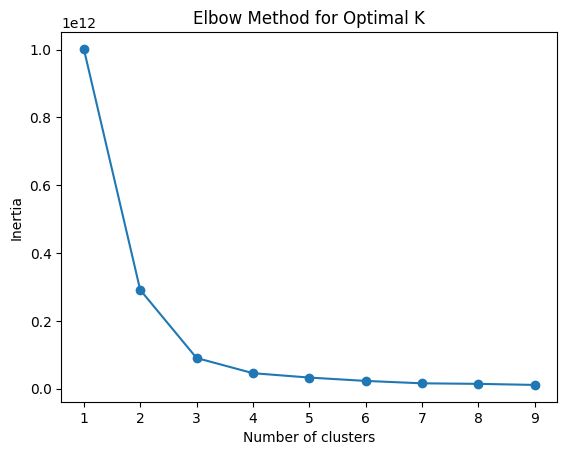

In [54]:
cluster_inertia = []

for k in range(1,10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(prices_array)
    cluster_inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), cluster_inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

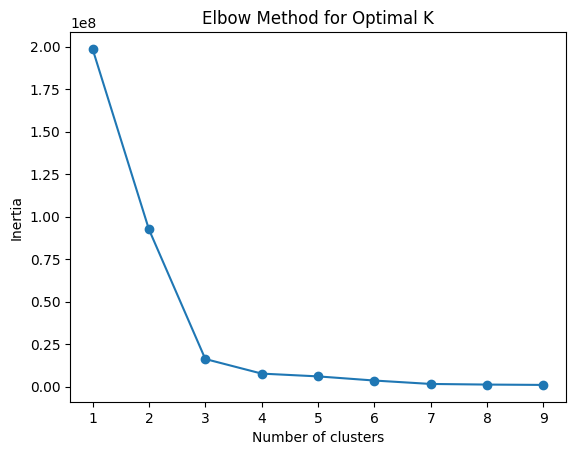

In [55]:
prices_array_without_any_outlier = np.array([item.price for item in first_outlier_detection.not_outliers]).reshape(-1, 1)

cluster_inertia_no_outlier = []

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(prices_array_without_any_outlier)
    cluster_inertia_no_outlier.append(kmeans.inertia_)

plt.plot(range(1, 10), cluster_inertia_no_outlier, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

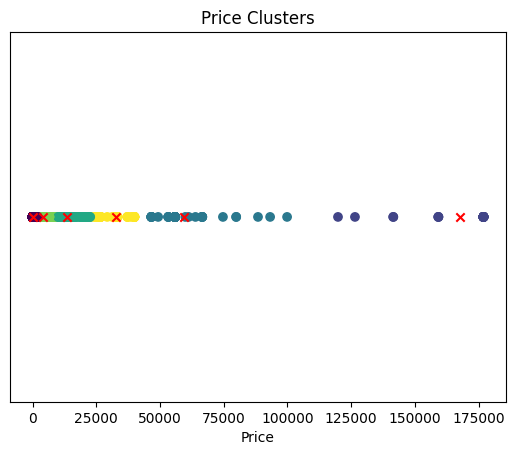

In [56]:
# 3 clusters for no outliers + 3 for outliers detections
prices_array_bis = np.array(prices_without_outliers).reshape(-1, 1)

# we assume 6 clusters: S, A, B, C, D, E
kmeans_with_outlier_bis = KMeans(n_clusters=6, random_state=0)
price_clusters_bis = kmeans_with_outlier_bis.fit_predict(prices_array_bis)

price_cluster_centers_bis = kmeans_with_outlier_bis.cluster_centers_ # for visualization

plt.scatter(prices_array_bis, [0]*len(prices_array_bis), c=price_clusters_bis, cmap='viridis', marker='o')
plt.scatter(price_cluster_centers_bis, [0]*len(price_cluster_centers_bis), color='red', marker='x')  # cluster centers
plt.title('Price Clusters')
plt.xlabel('Price')
plt.yticks([])  # no need foy-axis
plt.show()

In [57]:
price_clusters_bis

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [63]:
def to_list(i: int):
    return [1 if j == i else 0 for j in range(6)]

name_with_cluster = [(name, to_list(int(cluster))) for name, cluster in zip(names_without_outliers, price_clusters_bis)]
name_with_cluster

[('015d9b353acb20db3cdbc05f1386aab18cd5166d9b0bdd26fae7e163ef29786a',
  [1, 0, 0, 0, 0, 0]),
 ('b3533b5e5ae6e2bd6d0f7bcca2239e78c4c422f84324fe091021fcdf68c0ff7c',
  [1, 0, 0, 0, 0, 0]),
 ('7a70ed1d8643800ae1e2e596db3af8a9a9e5a32b2297ec99ed8e9ccf1690c641',
  [1, 0, 0, 0, 0, 0]),
 ('a19cac5720bd4f47228521419907354dd0e5420ae01a00a054d84cd00a1f0d36',
  [1, 0, 0, 0, 0, 0]),
 ('34c782d6ab2f88fc0b45dd2bfcd5db2edd65e5b00a588ba5910f553e6bf61da3',
  [1, 0, 0, 0, 0, 0]),
 ('e18c1dcf3bd36d11f2d35c25af3ad7f9429a9da20f4e9447d6ca25bf82983566',
  [0, 0, 1, 0, 0, 0]),
 ('a3dc2bb31ef0723980ab180fc46a6cca475e530b4efc352982e2190c44648d41',
  [1, 0, 0, 0, 0, 0]),
 ('32b4a72c6b5e0e9cb5397af90e17d3fb3a01c5530131539c58c0efb2d5aa2af9',
  [1, 0, 0, 0, 0, 0]),
 ('def17fb9ac6ad54fefca12d4f4b0c6646980e137f8077558f6815f4344c2193a',
  [1, 0, 0, 0, 0, 0]),
 ('00a6d4fcd3e33067c0182262465e76ea19869cf63c3fc911f22de11b176d058f',
  [1, 0, 0, 0, 0, 0]),
 ('fd695a7ab249c6e2c5c1eae7eae203daf1463f6a2f127608d24fbb49ebf1cf89',


## transforming json sample into list

In [25]:
BASIC_FILE = "0a0a5c89a084f5bceff3b83618846d57b03c6ee5d0758ac31f9a957ccf4ff66e.json"

with open(os.path.join(SAMPLE_DIR, BASIC_FILE), "r") as f:
    obj = json.load(f)
obj.keys()


dict_keys(['id', 'rarity', 'ilvl', 'identified', 'priceInChaos', 'levelRequirement', 'socket', 'influences', 'fractured', 'synthesised', 'duplicated', 'split', 'corrupted', 'qualities', 'valuatedStats'])

In [26]:
# how many rarity
rarity = []
for file in os.listdir(SAMPLE_DIR):
    if file.endswith(".json"):
        with open(os.path.join(SAMPLE_DIR, file), 'r') as f:
            data = json.load(f)
            if data['rarity'] not in rarity:
                rarity.append(data['rarity'])
rarity

['Rare', 'Magic', 'Normal']

In [27]:
# how many socket
socket = []
for file in os.listdir(SAMPLE_DIR):
    if file.endswith(".json"):
        with open(os.path.join(SAMPLE_DIR, file), 'r') as f:
            data = json.load(f)
            if data['socket'] not in socket:
                socket.append(data['socket'])
socket

['N', 'A', 'B', 'R', 'G', 'W']

In [28]:
# input will be the result of json.load(f)
def rarity_array(data):
    rarity = data['rarity']
    if rarity == "Normal":
        return [1, 0, 0]
    elif rarity == "Magic":
        return [0, 1, 0]
    elif rarity == "Rare":
        return [0, 0, 1]
    else:
        return [0, 0, 0]


In [29]:
def socket_array(data):
    socket = data['socket']
    if socket == 'N':
        return [1, 0, 0, 0, 0, 0]
    elif socket == 'A':
        return [0, 1, 0, 0, 0, 0]
    elif socket == 'B':
        return [0, 0, 1, 0, 0, 0]
    elif socket == 'R':
        return [0, 0, 0, 1, 0, 0]
    elif socket == 'G':
        return [0, 0, 0, 0, 1, 0]
    elif socket == 'W':
        return [0, 0, 0, 0, 0, 1]
    else:
        return [0, 0, 0, 0, 0, 0]

In [30]:
def identified_array(data):
    identified = data['identified']
    if identified:
        return [1, 0]
    else:
        return [0, 1]

In [31]:
def influence_array(data):
    influences = data['influences']
    return [
        1 if influences['warlord'] else 0,
        1 if influences['hunter'] else 0,
        1 if influences['redeemer'] else 0,
        1 if influences['crusader'] else 0,
        1 if influences['shaper'] else 0,
        1 if influences['elder'] else 0,
    ]

In [32]:
def fractured_array(data):
    fractured = data['fractured']
    if fractured:
        return [1, 0]
    else:
        return [0, 1]

In [33]:
def synthesised_array(data):
    synthesised = data['synthesised']
    if synthesised:
        return [1, 0]
    else:
        return [0, 1]

In [34]:
def duplicated_array(data):
    duplicated = data['duplicated']
    if duplicated:
        return [1, 0]
    else:
        return [0, 1]

In [35]:
def split_array(data):
    split = data['split']
    if split:
        return [1, 0]
    else:
        return [0, 1]

In [36]:
def corrupted_array(data):
    corrupted = data['corrupted']
    if corrupted:
        return [1, 0]
    else:
        return [0, 1]

In [37]:
def qualities_array(data):
    qualities = data['qualities']
    return [
        qualities["attack"],
        qualities["attribute"],
        qualities["caster"],
        qualities["critical"],
        qualities["defense"],
        qualities["elemental"],
        qualities["lifeAndMana"],
        qualities["physicalAndChaos"],
        qualities["resistance"],
        qualities["speed"]
    ]

In [38]:
[i['id'] for i in obj["valuatedStats"]]

['accuracy_rating',
 'accuracy_rating_+%',
 'accuracy_rating_+%_during_onslaught',
 'action_speed_-%',
 'add_frenzy_charge_on_kill_%_chance',
 'add_frenzy_charge_on_skill_hit_%',
 'add_frenzy_charge_when_hit_%',
 'add_power_charge_on_critical_strike_%',
 'add_power_charge_on_kill_%_chance',
 'additional_all_attributes',
 'additional_block_%',
 'additional_chaos_resistance_against_damage_over_time_%',
 'additional_dexterity',
 'additional_dexterity_and_intelligence',
 'additional_intelligence',
 'additional_maximum_all_resistances_%',
 'additional_physical_damage_reduction_%_during_flask_effect',
 'additional_physical_damage_reduction_%_vs_abyssal_monsters',
 'additional_physical_damage_reduction_%_while_affected_by_determination',
 'additional_physical_damage_reduction_%_while_moving',
 'additional_spell_block_%',
 'additional_strength',
 'additional_strength_and_dexterity',
 'additional_strength_and_intelligence',
 'additive_vaal_skill_damage_modifiers_apply_to_all_skills',
 'all_attr

In [39]:
def valuated_stats_array(data):
    valuated = data["valuatedStats"]
    sorted_valuated = sorted(valuated, key=lambda p: p["id"])
    return [p["value"] for p in sorted_valuated]


In [40]:
def from_data_to_array(data):
    return rarity_array(data) + [data['ilvl']] + identified_array(data) + [data['levelRequirement']] + socket_array(data) + influence_array(data) + fractured_array(data) + synthesised_array(data) + duplicated_array(data) + split_array(data) + corrupted_array(data) + qualities_array(data) + valuated_stats_array(data)

In [41]:
obj_data = from_data_to_array(obj)

In [42]:
obj_data

[0,
 0,
 1,
 84,
 1,
 0,
 67,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 20,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 4.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 13.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 48.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,

In [65]:
columns = ["object_id"] + [f"data_{i}" for i in range(len(obj_data))]
df = pd.DataFrame(columns=columns)

In [66]:
lenght = len(obj_data)
step = 0
for file in os.listdir(SAMPLE_DIR):
    if file.endswith(".json"):
        with open(os.path.join(SAMPLE_DIR, file), 'r') as f:
            step += 1
            if step % 1000 == 0:
                print(f"{step}")
            data = json.load(f)
            row = [data["id"]] + from_data_to_array(data)
            if len(row)-1 != lenght:
                print(f"error with {file}. Expected length of {lenght} but got {len(row)-1} at iteration {step}")
            else:
                df.loc[len(df)] = row
            


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
error with 60a165a83737b8240cf2a77b52f32cd884e30b6edb9ced43efa8ecc0c7bde0af.json. Expected length of 913 but got 914 at iteration 21107
22000
23000
error with 09c372f9ca5f910702fbd7a2e3eeaccbd4f34ad44c7e8ce0d5431ff7101cb9db.json. Expected length of 913 but got 914 at iteration 23924
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000


In [67]:
df.to_csv("data_50k.csv", index=False, sep=";")

In [44]:
if not 'df' in locals():
    df = pd.read_csv("data_50k.csv", sep=";")

In [45]:
df.describe()

,data_0,data_1,data_2,data_3,data_4,data_5,data_6,data_7,data_8,data_9,...,data_903,data_904,data_905,data_906,data_907,data_908,data_909,data_910,data_911,data_912
count,48805.000000,48805.000000,48805.000000,48805.000000,48805.0,48805.0,48805.000000,48805.000000,48805.000000,48805.000000,...,48805.0,48805.0,48805.000000,48805.0,48805.000000,48805.000000,48805.000000,48805.000000,48805.0,48805.0
mean,0.008544,0.016064,0.975392,80.773691,1.0,0.0,55.572564,0.935334,0.033951,0.010163,...,0.0,0.0,0.001127,0.0,0.032476,0.003504,0.040570,0.005553,0.0,0.0
std,0.092040,0.125723,0.154929,7.701605,0.0,0.0,11.995782,0.245937,0.181106,0.100299,...,0.0,0.0,0.178381,0.0,0.767596,0.388403,0.854002,0.502177,0.0,0.0
min,0.000000,0.000000,0.000000,2.000000,1.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,0.000000,0.000000,1.000000,80.000000,1.0,0.0,48.000000,1.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
50%,0.000000,0.000000,1.000000,83.000000,1.0,0.0,59.000000,1.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
75%,0.000000,0.000000,1.000000,85.000000,1.0,0.0,64.000000,1.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
max,1.000000,1.000000,1.000000,100.000000,1.0,0.0,80.000000,1.000000,1.000000,1.000000,...,0.0,0.0,32.000000,0.0,20.000000,49.000000,20.000000,50.000000,0.0,0.0


In [48]:
df.head()

,object_id,data_0,data_1,data_2,data_3,data_4,data_5,data_6,data_7,data_8,...,data_903,data_904,data_905,data_906,data_907,data_908,data_909,data_910,data_911,data_912
0,015d9b353acb20db3cdbc05f1386aab18cd5166d9b0bdd...,0,0,1,76,1,0,35,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,b3533b5e5ae6e2bd6d0f7bcca2239e78c4c422f84324fe...,0,0,1,82,1,0,57,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7a70ed1d8643800ae1e2e596db3af8a9a9e5a32b2297ec...,0,0,1,85,1,0,64,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,a19cac5720bd4f47228521419907354dd0e5420ae01a00...,0,0,1,83,1,0,59,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,34c782d6ab2f88fc0b45dd2bfcd5db2edd65e5b00a588b...,0,0,1,83,1,0,44,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
# define a new dataframe without outliers and with cluster number
outliers_to_exclude = [outlier.name.removesuffix(".json") for outlier in forth_outlier_detection.upper_outliers]
df_no_outliers = df[~df['object_id'].isin(outliers_to_exclude)]

for obj_id, int_list in name_with_cluster:
    if obj_id in df_no_outliers['object_id'].values:
        float_list = [float(i) for i in int_list]
        row_index = df_no_outliers[df_no_outliers['object_id'] == obj_id].index[0]
        for i, value in enumerate(float_list):
            column_name = f'rank_vector_{i+1}'
            if column_name not in df_no_outliers.columns:
                df_no_outliers[column_name] = 0.0
            df_no_outliers.loc[row_index, column_name] = value

/tmp/ipykernel_447312/3978398659.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers[column_name] = 0.0
/tmp/ipykernel_447312/3978398659.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers[column_name] = 0.0
/tmp/ipykernel_447312/3978398659.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [66]:
df_no_outliers.to_csv("data_50k_no_outliers_with_cluster.csv", index=False, sep=";")